<a href="https://colab.research.google.com/github/hyfoo-bot/project/blob/main/data%20analyticsNeural_networks_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
import os
import shutil
import random
import glob
import gdown
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

 We will be using Tensorflow and Keras, coding frameworks developed by Google for the efficient development of AI software and tools. Using such frameworks (another is called PyTorch), constructing neural network layers can be performed in just a few lines of code, and complicated operations like backpropagation happen 'under the hood' and do not require you to write the matrix algebra from scratch.

You will need your graphics processing unit (GPU), provided in Colab free of charge. We are not really doing graphics processing like you would when playing a graphics-intensive computer game, but GPUs are capable of performing matrix operations highly efficiently, hence their tremendous power in AI training.

In the top right hand corner of the screen, ensure that the Runtime and GPU is enabled (it will say 'T4', referring to the Nvidia Tesla T4 GPU). The code below will ensure that the GPU has been correctly selected.

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)

tf.config.set_visible_devices(physical_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Let's start by downloading our example data, a .zip of 1,300 JPG pictures of cats and dogs, and extracting it locally.

The  images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!gdown https://drive.google.com/uc?id=1tQyaUL7-5JwR87PCFue2p1nO9ta0zUu1 # file that I shared from my google drive


Downloading...
From (original): https://drive.google.com/uc?id=1tQyaUL7-5JwR87PCFue2p1nO9ta0zUu1
From (redirected): https://drive.google.com/uc?id=1tQyaUL7-5JwR87PCFue2p1nO9ta0zUu1&confirm=t&uuid=fff242e3-8f22-45fa-91e1-04d0ffd0d314
To: /content/dogs-vs-cats.zip
100% 29.5M/29.5M [00:00<00:00, 205MB/s]


In [ ]:
import os
import zipfile

local_zip = 'dogs-vs-cats.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

The contents of the .zip are extracted to the base directory , which contains train and validation subdirectories for the training and validation datasets, which in turn each contain cats and dogs subdirectories. Let's define each of these directories:

In [ ]:
base_path = 'dogs-vs-cats'
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

As usual, we do a quick visualization of the data. Here we display a random selection of images from each folder.

dogs-vs-cats/train/cat/cat.6411.jpg
dogs-vs-cats/train/cat/cat.5315.jpg
dogs-vs-cats/train/cat/cat.966.jpg
dogs-vs-cats/train/cat/cat.10784.jpg
dogs-vs-cats/train/cat/cat.325.jpg
dogs-vs-cats/train/cat/cat.9801.jpg
dogs-vs-cats/train/dog/dog.2661.jpg
dogs-vs-cats/train/dog/dog.7234.jpg
dogs-vs-cats/train/dog/dog.11826.jpg
dogs-vs-cats/train/dog/dog.2454.jpg
dogs-vs-cats/train/dog/dog.6435.jpg
dogs-vs-cats/train/dog/dog.2260.jpg


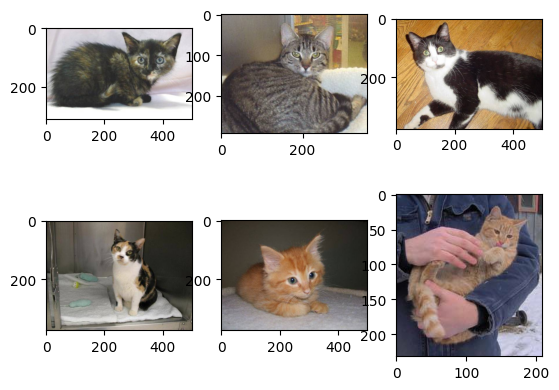

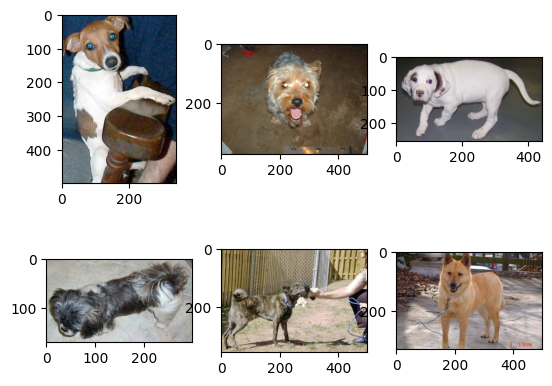

In [ ]:
for each in ['cat','dog']:
  plt.figure()
  image_files = os.listdir(train_path + '/' + each)
  random_files = random.sample(image_files, 6)
  for i, file in enumerate(random_files):
      fullpath = train_path + "/" + each + "/" + file
      print(fullpath)
      img=plt.imread(fullpath)
      plt.subplot(2, 3, i+1)
      plt.imshow(img)

By the way, Google Colab has Gemini (Google's chatbot) integrated, so if you need help understanding or modifying these code snippets, you may want to right-click on the code and select 'Explain code'. Remember to always use chatbot outputs with caution.

ImageDataGenerator is an important tool in Keras that helps to pre-process the data for training. For example, you noticed the images above are all of different sizes. This would be a problem for the neural network. ImageDataGenerator is configured below to resize all images to dimension 224 x 224. The minibatch size is also defined at 16.

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=16)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=16)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=16, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Now we display one of minibatches that has been prepared by ImageDataGenerator. The images have been resized and the colours look wonky, due to rescaling of the pixel values performed as a pre-processing step.

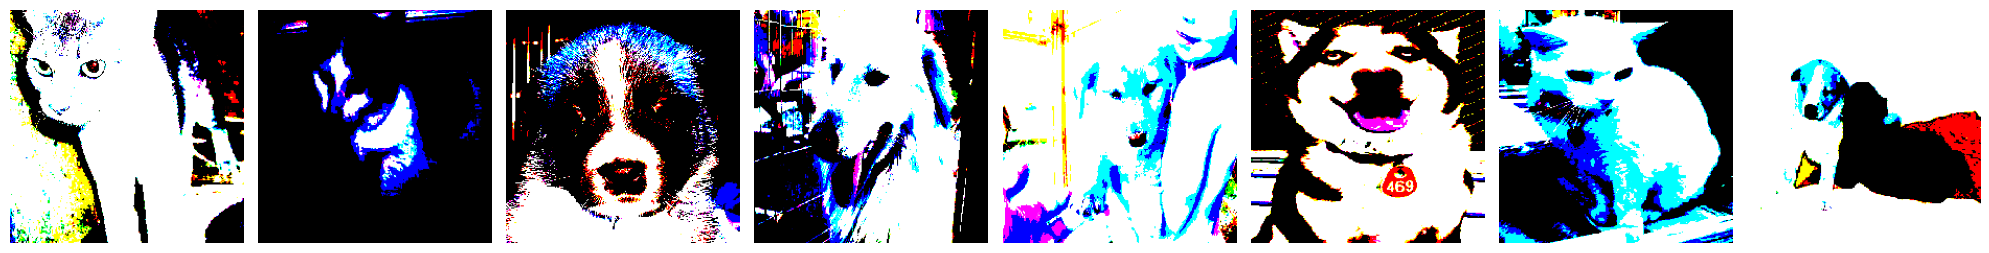

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [ ]:
imgs, labels = next(train_batches)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 8, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs)
print(labels)

Go nuts and build your neural network! You can follow the suggested code in the lecture notes or try out your own ideas. Even Colab has suggestions for you!

In [ ]:
# YOUR CODE HERE #
# define model layers
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])
# compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# train
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 - 13s - 201ms/step - accuracy: 0.5630 - loss: 22.4755 - val_accuracy: 0.5900 - val_loss: 6.1652
Epoch 2/10
63/63 - 12s - 187ms/step - accuracy: 0.7170 - loss: 2.9654 - val_accuracy: 0.5800 - val_loss: 4.1428
Epoch 3/10
63/63 - 3s - 45ms/step - accuracy: 0.8090 - loss: 1.3874 - val_accuracy: 0.6000 - val_loss: 6.5554
Epoch 4/10
63/63 - 4s - 61ms/step - accuracy: 0.8950 - loss: 0.6010 - val_accuracy: 0.6100 - val_loss: 3.0547
Epoch 5/10
63/63 - 3s - 48ms/step - accuracy: 0.9720 - loss: 0.0969 - val_accuracy: 0.6550 - val_loss: 3.0009
Epoch 6/10
63/63 - 3s - 45ms/step - accuracy: 0.9740 - loss: 0.0823 - val_accuracy: 0.6850 - val_loss: 3.0564
Epoch 7/10
63/63 - 3s - 43ms/step - accuracy: 0.9860 - loss: 0.0434 - val_accuracy: 0.6200 - val_loss: 3.3346
Epoch 8/10
63/63 - 5s - 83ms/step - accuracy: 0.9970 - loss: 0.0123 - val_accuracy: 0.6750 - val_loss: 2.8475
Epoch 9/10
63/63 - 5s - 80ms/step - accuracy: 0.9960 - loss: 0.0079 - val_accuracy: 0.6400 - val_loss: 2.8256
Epoch 10/10
63/6

Notice that training accuracy quickly hits near-100% but the validation accuracy plateaus earlier.

Now we obtain the test accuracy and present it in a confusion matrix.

In [ ]:
y_test = test_batches.classes
output_layer = model.predict(x=test_batches, verbose=0)
y_pred = np.argmax(output_layer, axis=-1)


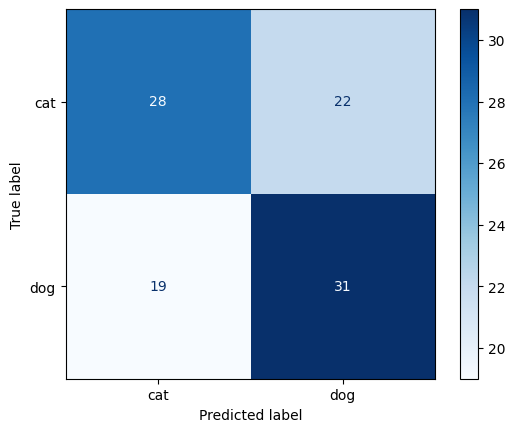

In [ ]:
# YOUR CODE HERE #
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

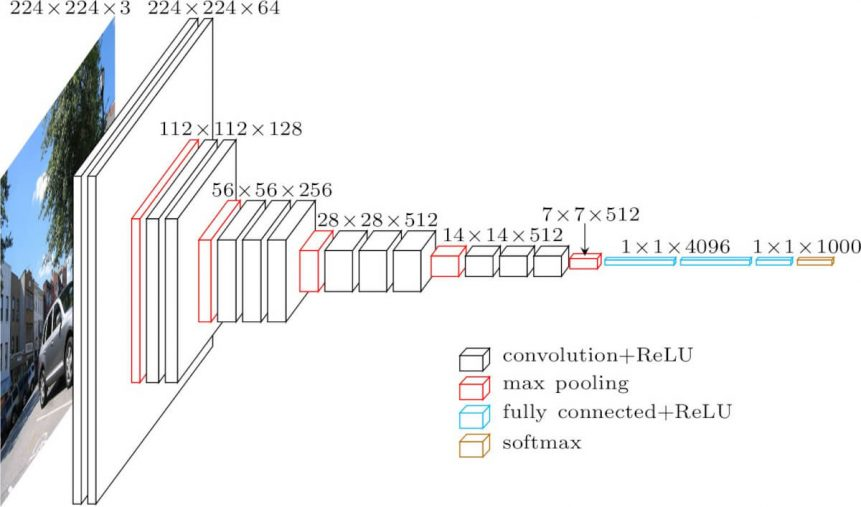

In [ ]:
# Download model - Internet connection needed
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

It should be possible to build our specific model on top of the trained VGG network, which has already learned useful features from a very large dataset. By copying the layers and weights, we can borrow its strength for our needs.

In [ ]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 4096)                │      16,781,312 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

Training this neural network from scratch would take weeks to finish. Here, we make the hidden layers untrainable:

In [ ]:
for layer in model.layers:
    layer.trainable = False

Add an output layer with only two categories to the new model:

In [ ]:
model.add(Dense(units=2, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc2 (Dense)                          │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

## Train the fine-tuned VGG16 model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5
63/63 - 25s - 399ms/step - accuracy: 0.7070 - loss: 0.9409 - val_accuracy: 0.9250 - val_loss: 0.2308
Epoch 2/5
63/63 - 22s - 347ms/step - accuracy: 0.9450 - loss: 0.1601 - val_accuracy: 0.9600 - val_loss: 0.1366
Epoch 3/5
63/63 - 6s - 88ms/step - accuracy: 0.9680 - loss: 0.1008 - val_accuracy: 0.9650 - val_loss: 0.1129
Epoch 4/5
63/63 - 5s - 78ms/step - accuracy: 0.9760 - loss: 0.0740 - val_accuracy: 0.9700 - val_loss: 0.0984
Epoch 5/5
63/63 - 5s - 83ms/step - accuracy: 0.9820 - loss: 0.0583 - val_accuracy: 0.9750 - val_loss: 0.0918


Does this do better than before?

In [ ]:
y_test = test_batches.classes
output_layer = model.predict(x=test_batches, verbose=0)
y_pred = np.argmax(output_layer, axis=-1)

Plot confusion matrix

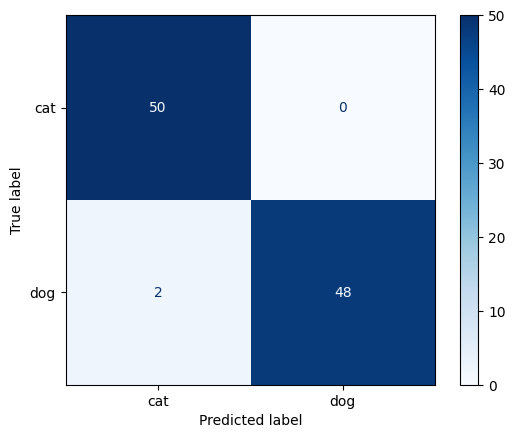

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cat', 'dog'])

disp.plot(cmap=plt.cm.Blues)
plt.show()